# Day-Averaged Yearly Profiles clustering

In [2]:
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from pathlib import Path
from collections import defaultdict

from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

logging.getLogger('matplotlib.font_manager').disabled = True

timestamp_range = pl.datetime_range(datetime(2024, 1, 1), datetime(2024, 12, 31), "1d", eager=True).cast(pl.Date)

In [9]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_category.csv')

input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d


Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


/var/folders/db/p0yj0j2s77j2q7kn7qv0ns640000gn/T/ipykernel_59147/4052892373.py:18: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  house_ids_subcat = result_df.filter(pl.col(large_cat) == subcat)['house_id'].to_list()


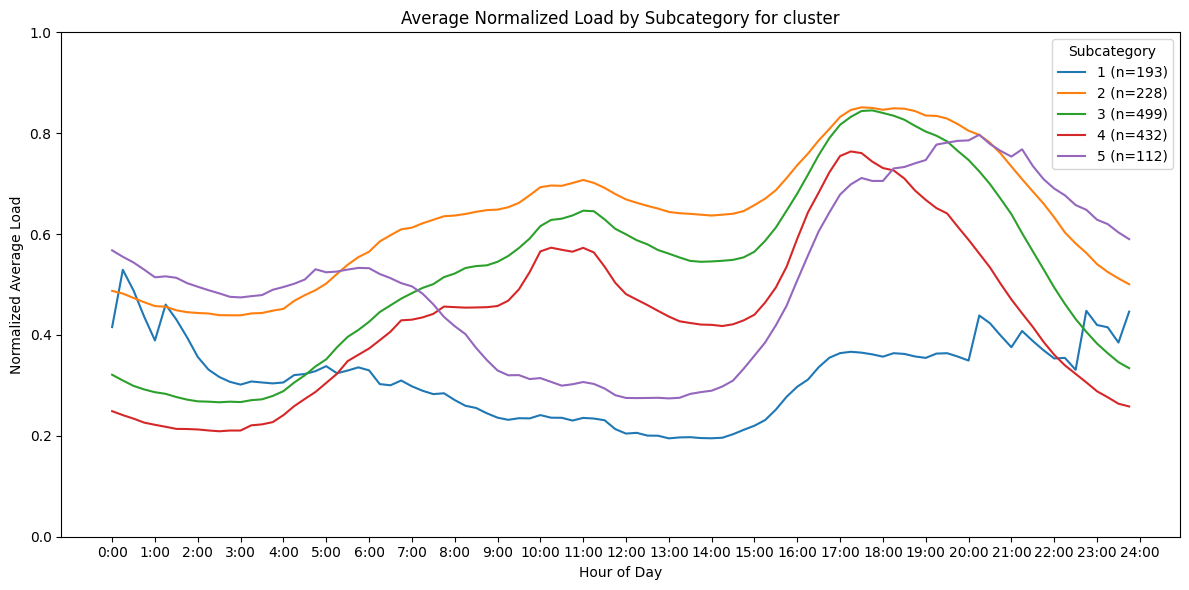

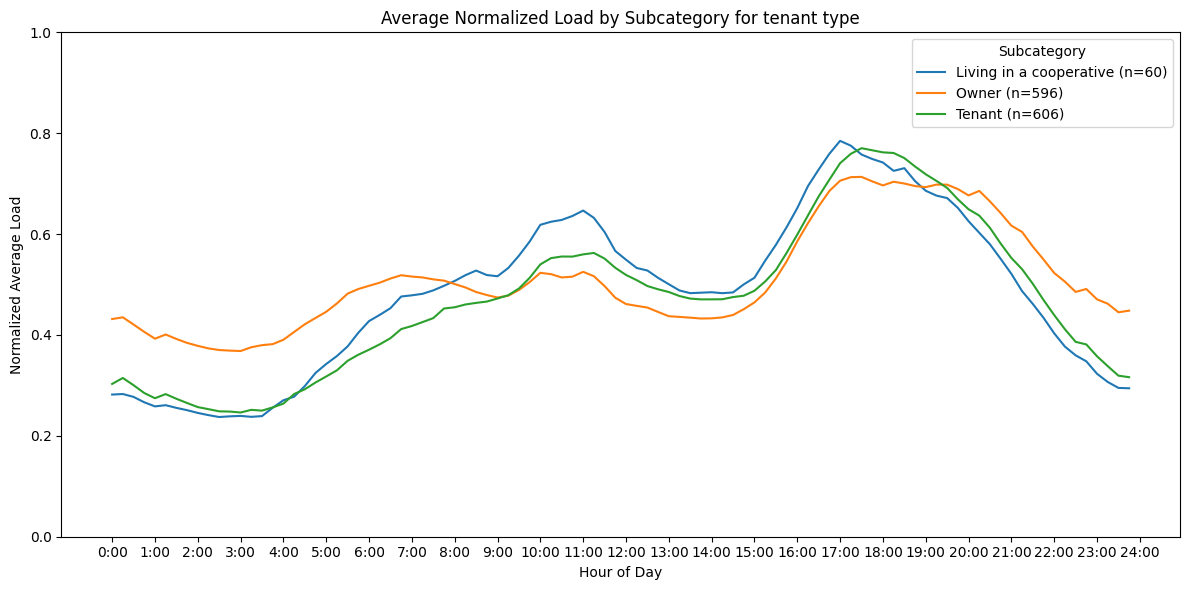

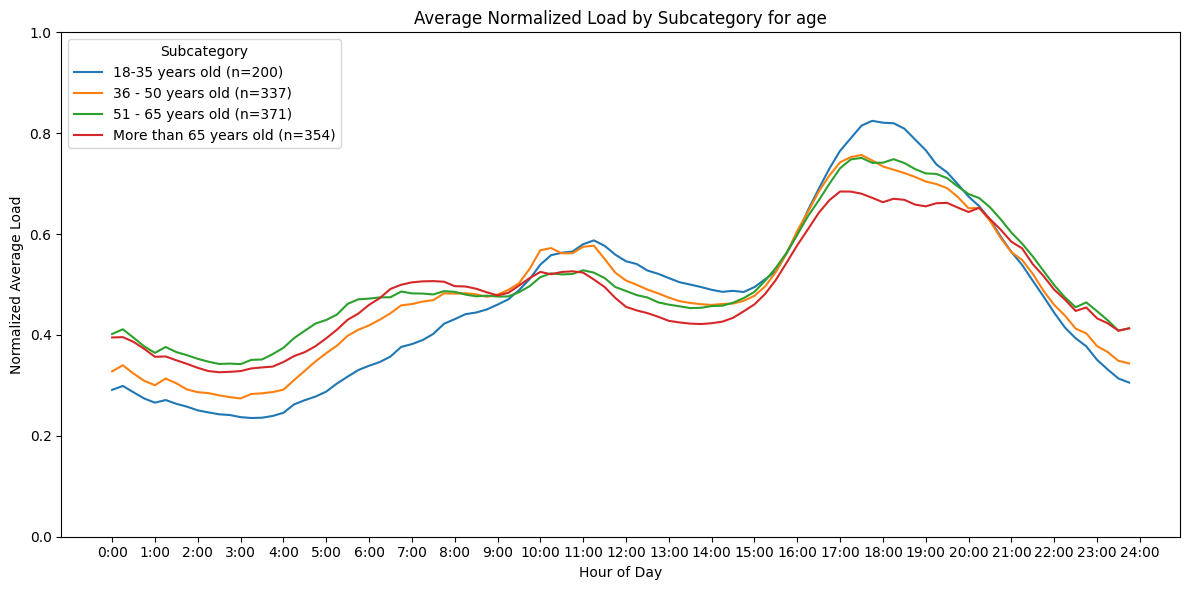

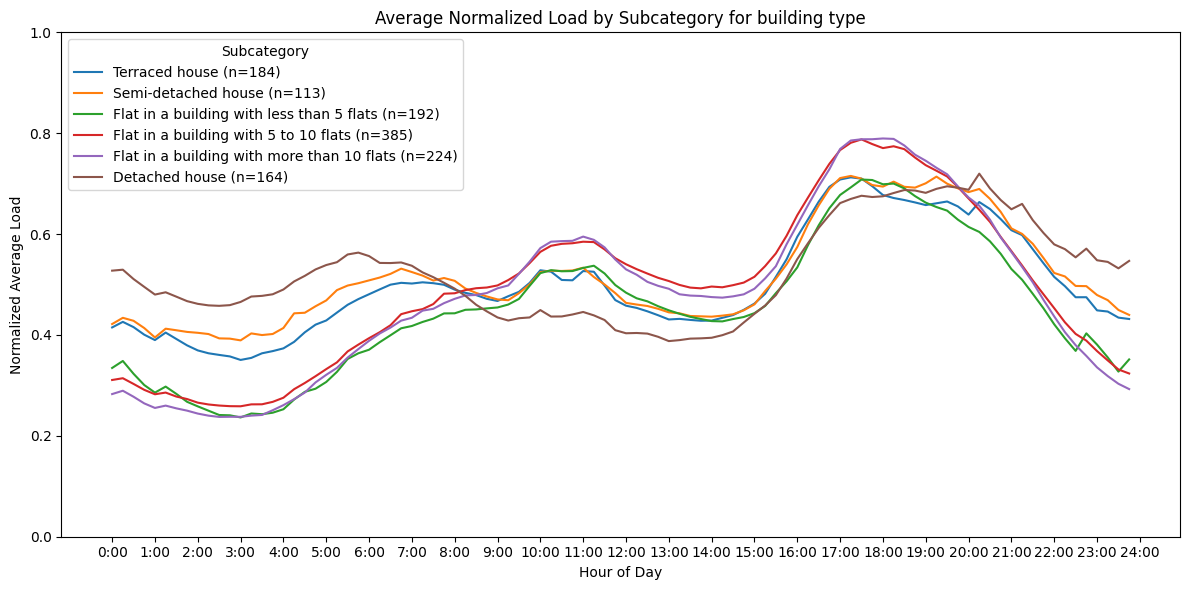

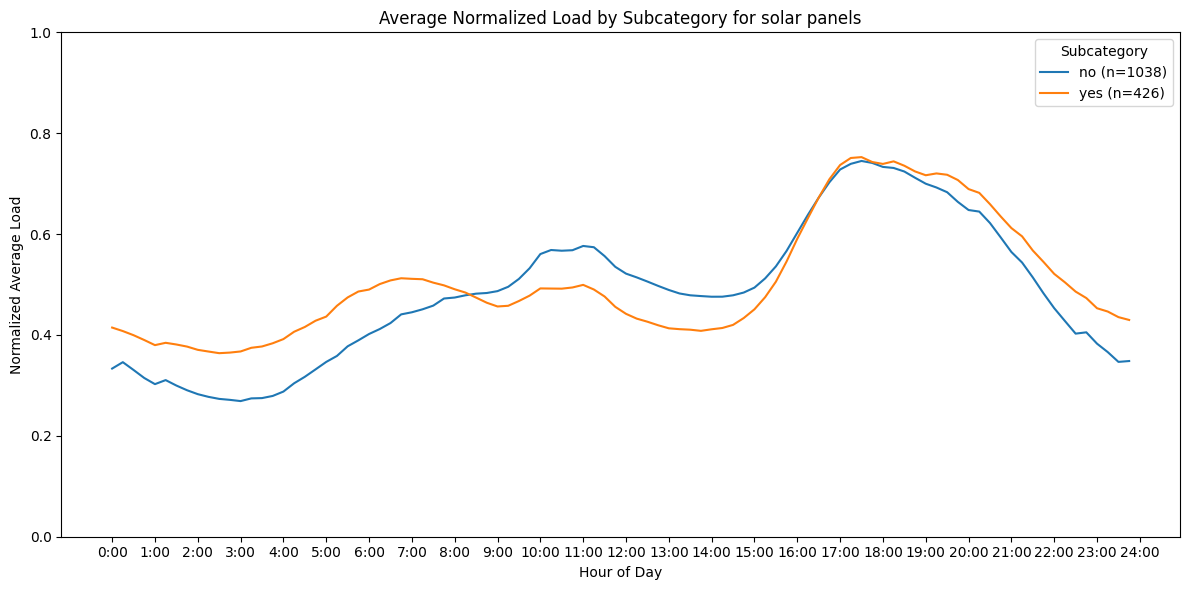

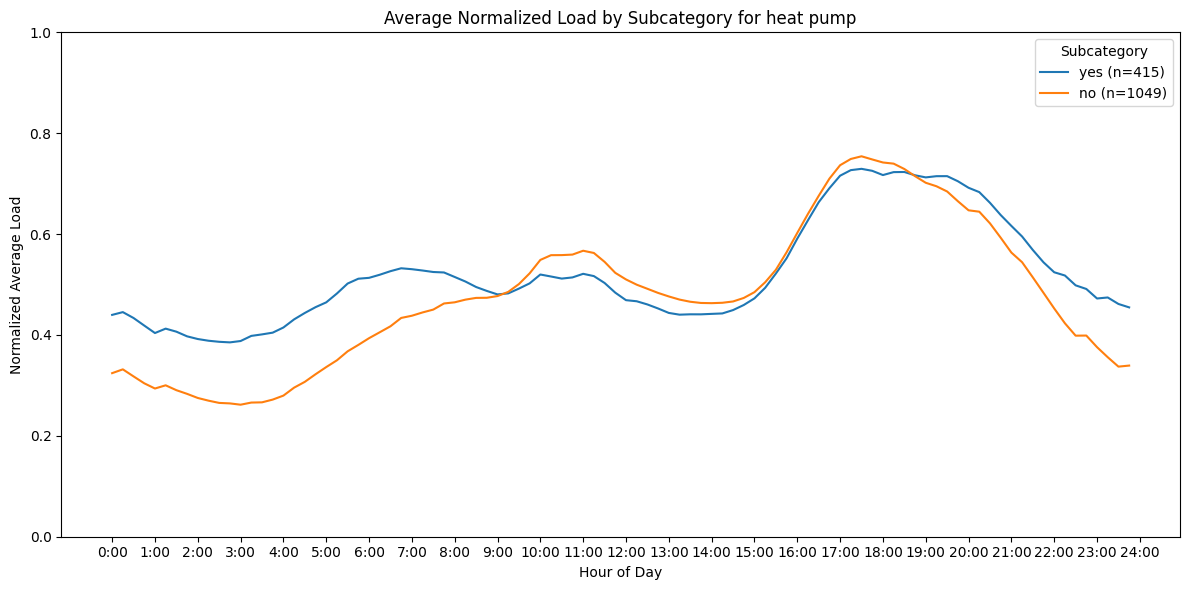

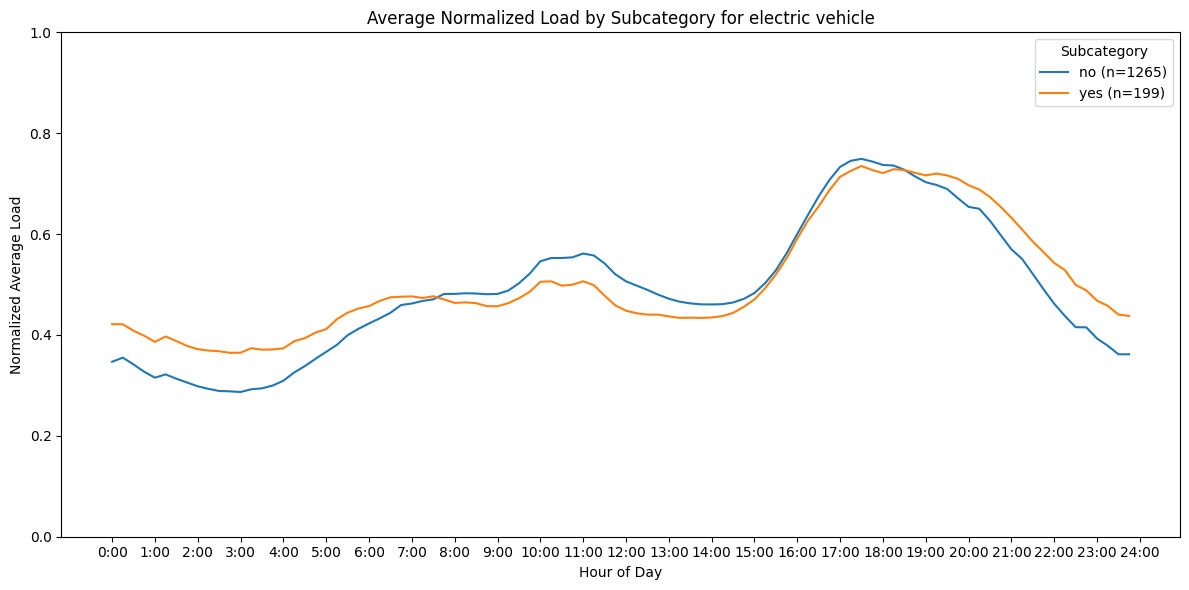

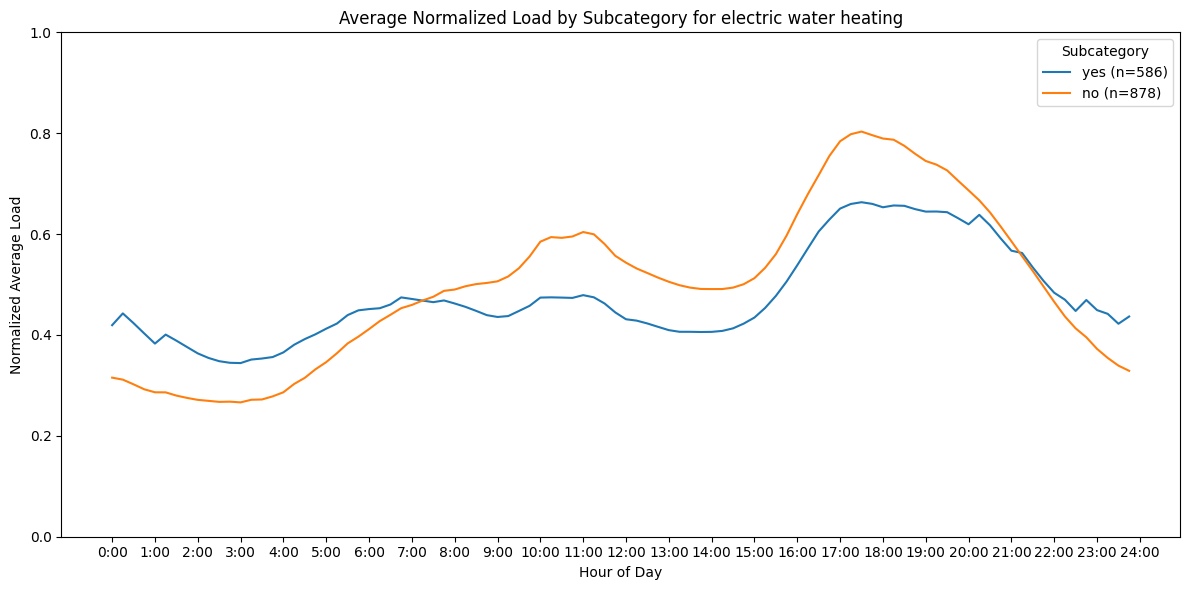

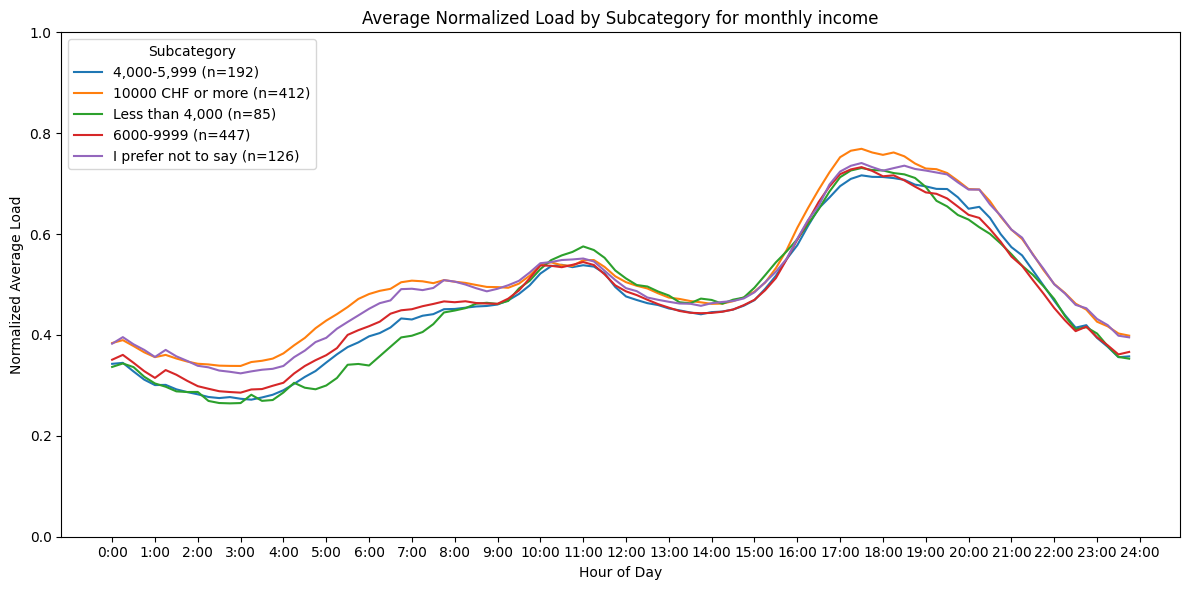

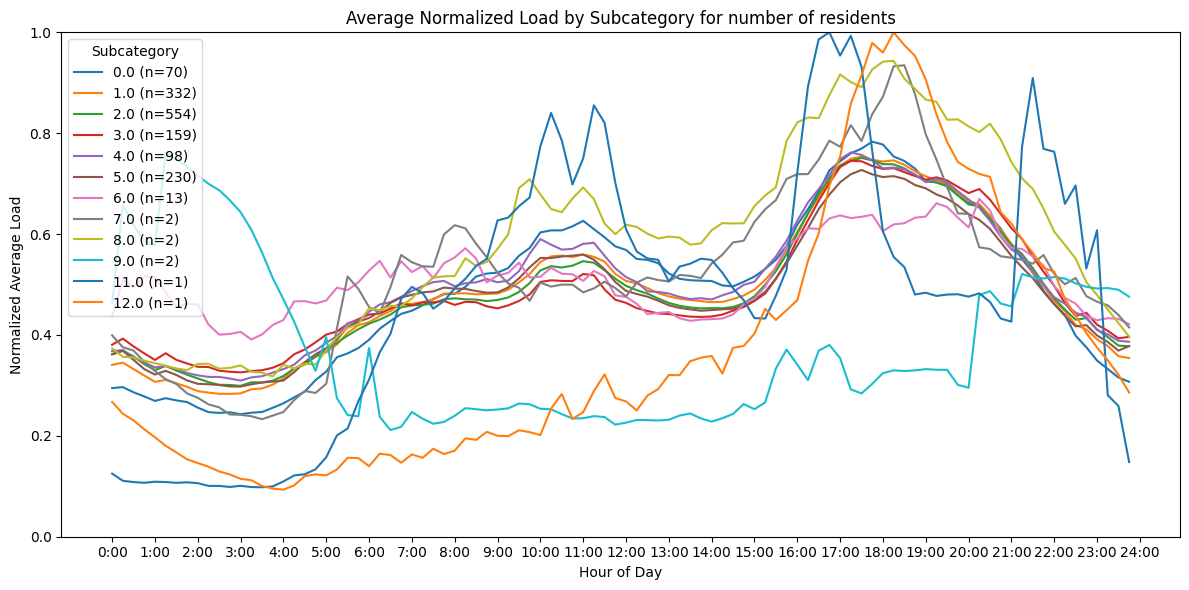

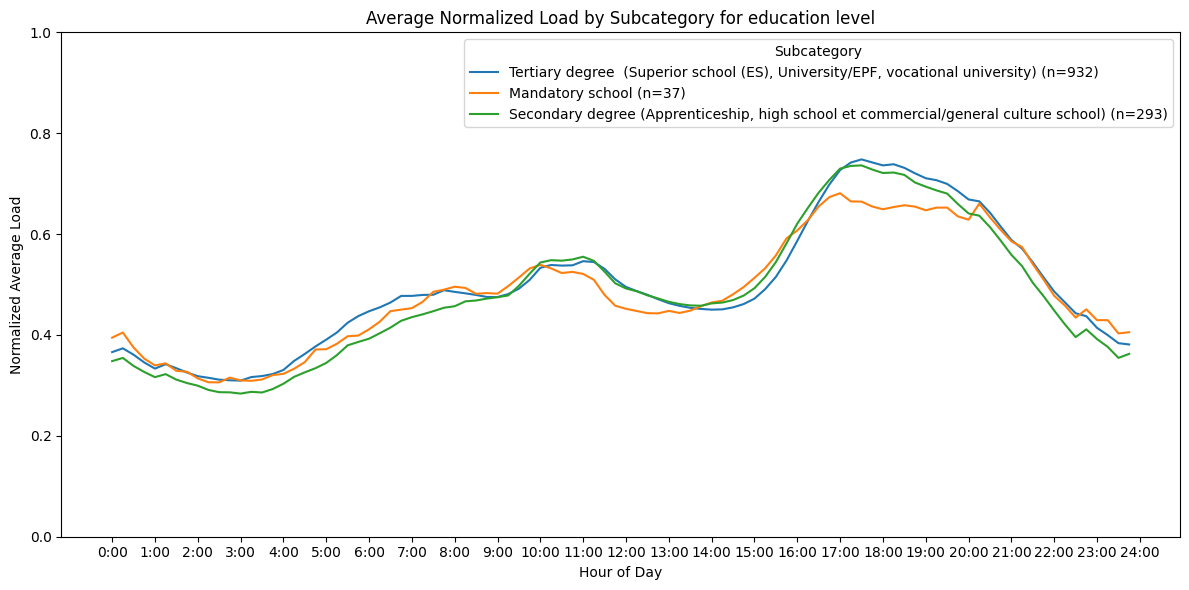

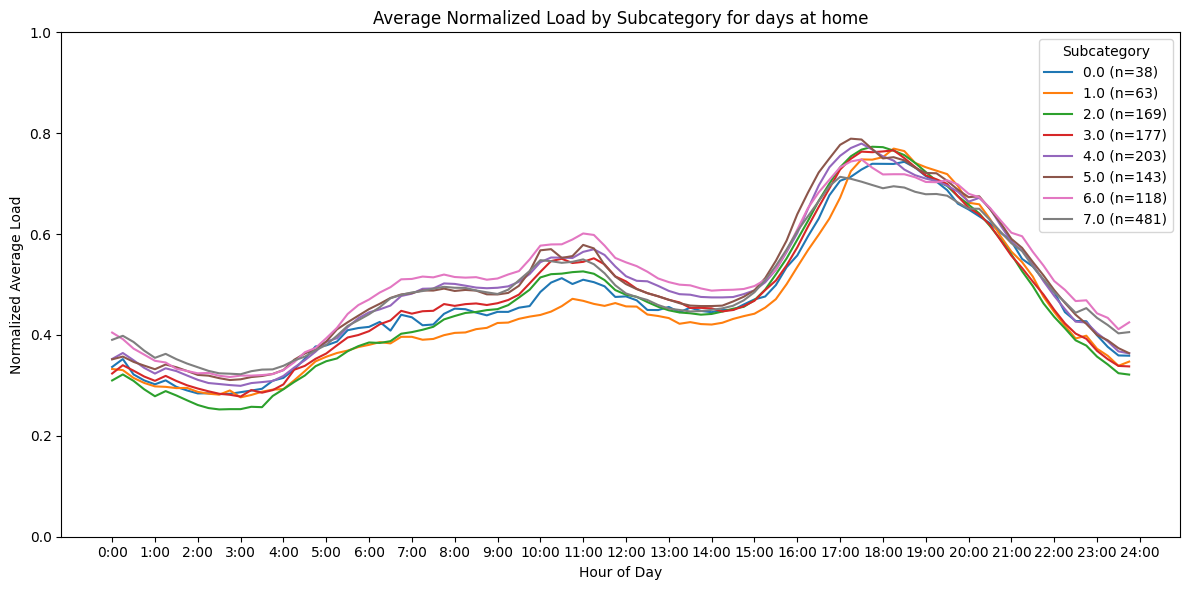

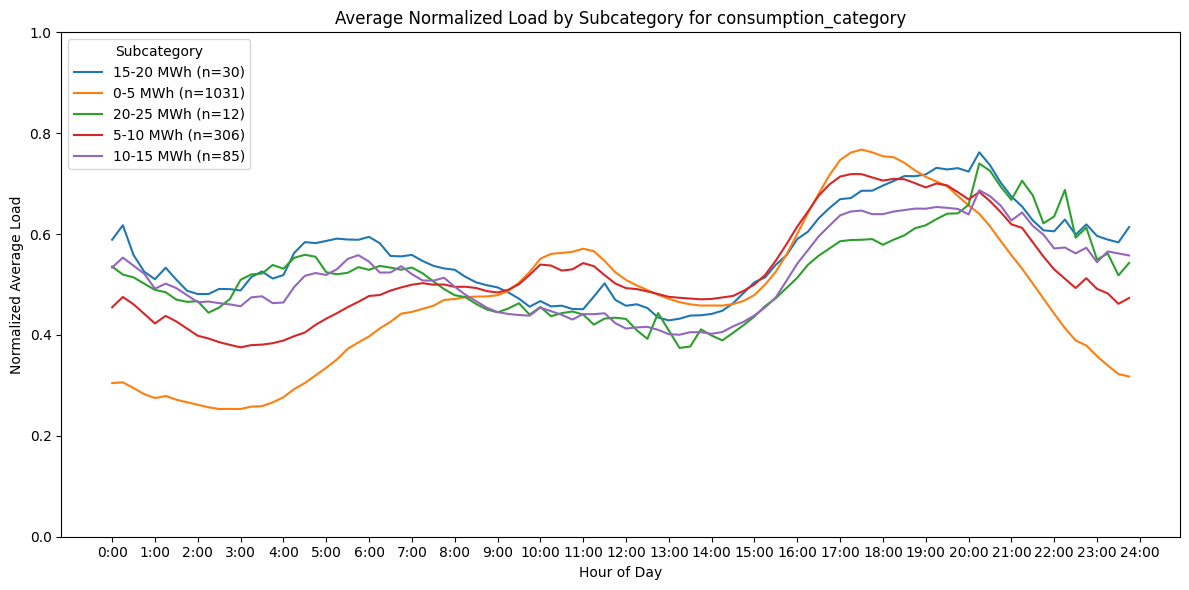

In [ ]:


# Map house_id to index in data_3d
filename_to_index = {house_id: idx for idx, house_id in enumerate(filename_list)}

# Dictionary to store mean curves: category_data[large_cat][subcategory] = mean_curve (shape (96,))
category_data = defaultdict(lambda: defaultdict(np.ndarray))

# Identify large category columns except 'house_id'
large_categories = result_df.columns[2:]

for large_cat in large_categories:
    # Extract unique subcategories for this large category
    subcategories = result_df[large_cat].unique().to_list()

    for subcat in subcategories:
        # Filter house_ids that belong to the subcategory
        house_ids_subcat = result_df.filter(pl.col(large_cat) == subcat)['house_id'].to_list()

        # Collect normalized hourly data for each house_id in the subcategory
        subcat_data = []
        for hid in house_ids_subcat:
            if hid in filename_to_index:
                idx = filename_to_index[hid]
                subcat_data.append(data_3d[idx, :, 0])  # shape (96,)

        if subcat_data:
            # Compute mean curve over all house_ids in subcategory
            mean_curve = np.mean(np.vstack(subcat_data), axis=0)
            category_data[large_cat][subcat] = mean_curve

# Plotting
for large_cat, subcat_dict in category_data.items():
    plt.figure(figsize=(12, 6))
    
    for subcat, mean_curve in subcat_dict.items():
        # Count how many house_ids correspond to this subcategory
        house_ids_subcat = result_df.filter(pl.col(large_cat) == subcat)['house_id'].to_list()
        count = len(house_ids_subcat)
        
        # Add count info to label
        label = f"{subcat} (n={count})"
        
        plt.plot(mean_curve, label=label)
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Normalized Average Load')
    plt.title(f'Average Normalized Load by Subcategory for {large_cat}')
    plt.xticks(ticks=[i*4 for i in range(25)], labels=[f'{i}:00' for i in range(25)])
    plt.legend(title='Subcategory')
    plt.ylim(0, 1)
    plt.grid(False)
    plt.tight_layout()
    plt.show()